# What you will find in this notebook

1. A concise implementation for the SRGAN model 
2. The preprocessing for the model (in tensorflow) withouth having to download it
3. Building the model arch. 
4. Visulzing the output; We compare the generated images with the og images, the low res ones and the lr after Bi-cubic interpolation. 

# Import Libraries 

In [1]:
# for plotting 
import matplotlib.pyplot as plt
import cv2
# for vectors manipultion 
import numpy as np

# for walking in the dir
import os

# tensorflow  libraries to preprocess the data
import tensorflow_addons as tfa
from tensorflow.keras.layers import RandomCrop
import tensorflow_transform as tft

# for building the network
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras import Model
from keras.layers import Conv2D
from keras import Input
from keras.layers import PReLU,LeakyReLU
from keras.layers import UpSampling2D
from keras.layers import BatchNormalization
from keras.layers import add,Dense, Flatten
from keras import activations

from tqdm import tqdm
from keras.models import load_model
import keras
import keras.utils
from keras import utils as np_utils
import keras.backend as K
import numpy as np 

In [2]:
ImgDataset=[]
i=0
for dirname, _, filenames in os.walk('../input/image-dataset/train2014/'):    
    for filename in filenames:
        if filename.endswith(".jpg"):
            ImgDataset.append(os.path.join(dirname, filename))
            i+=1 
print(i)

82783


# Data generator and the preporcessing 

In [3]:

randomcrop1 = RandomCrop(96,96)
min_maxScale = tf.keras.layers.Rescaling(scale= 1./255)
range_Scaling = tf.keras.layers.Rescaling(scale= 1./127.5,offset=-1)
def prepare_Image_tf(imgPath): 
    # Read the image
    '''img = tf.io.read_file(imgPath)
    img = tf.image.decode_jpeg(img, channels=0)'''
    img = tf.keras.utils.load_img(
    imgPath,
    grayscale=False,
    color_mode='rgb',
    )
    
    HR = randomcrop1(img)
    
    # constructing the LR images 
    LR= tfa.image.gaussian_filter2d(image= HR,
        filter_shape = (3, 3),
        sigma = 1.0,
        padding = 'REFLECT')
    
    LR = tf.image.resize(LR, [24, 24])
    LR = min_maxScale(LR)
    
    # Normalizing the HR images 
    HR = range_Scaling(HR)
    return LR,HR

In [4]:
def get_batch(getImg= prepare_Image_tf,dataset=ImgDataset,batchSize=16): 
    HRbatch=[]
    LRbatch=[]
    for counter,path in enumerate(dataset):
        LR,HR=getImg(path)
        HRbatch.append(HR)
        LRbatch.append(LR)
        if (counter+1)%batchSize == 0: 
            yield tf.stack(LRbatch),tf.stack(HRbatch)
            HRbatch=[]
            LRbatch=[]

# Visualizing a sample from the dataset 

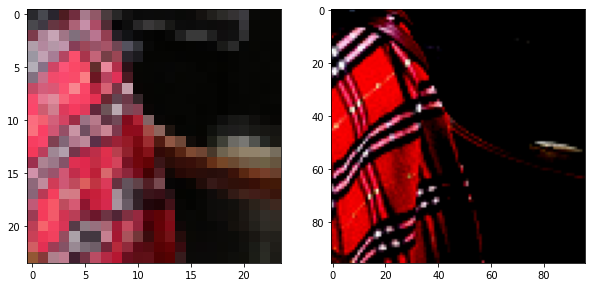

In [5]:
dataloader = get_batch()
LRB,HRB = next(dataloader)

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(LRB[8])
plt.subplot(1,2,2)
plt.imshow(HRB[8])

# Building the model 

## Discriminative Model

In [6]:
def repeatedBlock(INPUT,C,s):
    Block= Conv2D(C,(3,3),padding='same',strides=(s,s))(INPUT)
    BN= BatchNormalization(axis = -1)(Block)
    op= LeakyReLU(alpha=0.2)(BN)
    return op

def descriminator(INPUT):
    FILTERS=64
    Block = Conv2D(64,(3,3),padding='same')(INPUT)
    Block = LeakyReLU(alpha=0.2)(Block)
    layer= repeatedBlock(Block,FILTERS,2)
    for i in range(3):
        FILTERS*=2
        layer= repeatedBlock(layer,FILTERS,1)
        layer= repeatedBlock(layer,FILTERS,2)

    flattened= Flatten()(layer)
    layer2= Dense(1024)(flattened)
    layer3= LeakyReLU(alpha=0.2)(layer2)
    op= Dense(1,activation=activations.sigmoid)(layer3)
    return Model(inputs=INPUT, outputs=op)
  





## Generative model 

In [7]:
def upScaleBlock(INPUT):
    #use_bias=False
    Block=Conv2D(256,(3,3),padding='same',use_bias=False)(INPUT)
    Block2=UpSampling2D(size=2)(Block)
    #Block2= PixelShuffler()(Block)
    Block3=PReLU(shared_axes=[1, 2])(Block2)
    # the SHARED AXIS is used instead of the shufflerthat exists in pytorcha nd the real model
    # am not quite sure BUT if this is not ture then i'd have to implement or get a module for it 
  
    return Block3

  

In [8]:
def resBlock(INPUT):
    #use_bias=False
    Block=Conv2D(64,(3,3),padding='same',use_bias=False)(INPUT)
    #axis=-1
    BN=BatchNormalization(axis=-1)(Block)
    ACTIV=PReLU(shared_axes=[1, 2])(BN)

    Block2=Conv2D(64,(3,3),padding='same')(ACTIV)
    #axis=-1

    BN2=BatchNormalization(axis=-1)(Block2)

    # the SHARED AXIS is used instead of the shufflerthat exists in pytorcha nd the real model
    return add([INPUT,BN2])


In [9]:
def GAN_generator(INPUT):
    Block=Conv2D(64,(9,9),padding='same')(INPUT)
    layer=PReLU(shared_axes=[1, 2])(Block)
  
    #change
    layer2= resBlock(layer)
    for i in range(15):
        layer2= resBlock(layer2)
  
    Block2=Conv2D(64,(3,3),padding='same')(layer2)
    BN3=BatchNormalization(momentum=0.85)(Block2)
    layer3= add([layer,layer2])

    layer4= upScaleBlock(layer3)
    layer4= upScaleBlock(layer4)

    op=Conv2D(3,(9,9),padding='same')(layer4)
    return Model(inputs=INPUT,outputs=op)

### VGG19 

In [10]:
def create_vgg19(imgShape): 
    vgg= VGG19(include_top=False,
               weights="imagenet",
               input_shape=imgShape)
    model =Model(inputs=vgg.inputs,outputs=vgg.layers[20].output)
    model.trainable=False
    return model

vgg19=create_vgg19((96,96,3))

80150528/80134624 [==============================] - 0s 0us/step


## linking GAN networks 

In [11]:
def Link_GAN(generator, discriminator, vgg, lr, hr):
    generated_image = generator(lr)
    generated_features = vgg(generated_image)
    
    discriminator.trainable = False
    validity = discriminator(generated_image)
    
    return Model(inputs=[lr, hr], outputs=[validity, generated_features])

# Let's Train the model 

In [12]:
LR = Input(shape=(24,24,3))
HR = Input(shape=(96,96,3))
## Generator
Generator = GAN_generator(LR)
Generator.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 24, 24, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 24, 24, 64)   15616       input_2[0][0]                    
__________________________________________________________________________________________________
p_re_lu (PReLU)                 (None, 24, 24, 64)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 24, 24, 64)   36864       p_re_lu[0][0]                    
____________________________________________________________________________________________

In [13]:
## Discriminator
Discriminator = descriminator(HR)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

Discriminator.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])
Discriminator.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 96, 96, 64)        1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 96, 96, 64)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 48, 48, 64)        36928     
_________________________________________________________________
batch_normalization_33 (Batc (None, 48, 48, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 48, 48, 128)       7385

In [14]:
#Linking the models
GAN = Link_GAN(Generator, Discriminator, vgg19, LR, HR)
GAN.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer=optimizer)
GAN.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 24, 24, 3)]  0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 96, 96, 3)    2005571     input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
model_2 (Functional)            (None, 1)            23569217    model_1[0][0]                    
____________________________________________________________________________________________

#epochs = 100
#Generator = load_model('gen_e_55.h5', compile=False)
#Discriminator = load_model('dis_e_55.h5', compile=False)

Discriminator.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])

epochs = 30
BATCHSIZE=16 
NUM_SKIPPED_BS= 0
#Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((BATCHSIZE, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((BATCHSIZE,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    #Enumerate training over batches. 
    dataloader = get_batch(batchSize=BATCHSIZE)

    for b in tqdm(range(len(ImgDataset)//BATCHSIZE)):
        
        try:
            lr_imgs,hr_imgs = next(dataloader)
        except: 
            NUM_SKIPPED_BS+=1 
            continue
        
        fake_imgs = Generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        Discriminator.trainable = True
        d_loss_gen = Discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = Discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        Discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg19.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = GAN.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Report the progress during training. 
    if (e+1) % 5 == 0:
        print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 10 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        Generator.save("gen_e_"+ str(e+1) +".h5")

# Visualizing the reults

## Loss curves 

plt.subplot(1,2,1)
plt.plot(g_losses)
plt.title("the generative loss")
plt.subplot(1,2,2)
plt.plot(d_losses)
plt.title("the Discriminatie loss")

## Images after passing to the gen model

In [15]:
Generator = load_model('/kaggle/input/SRGAN-Weights-20EPOCH-coco/gen_e_20.h5', compile=False)


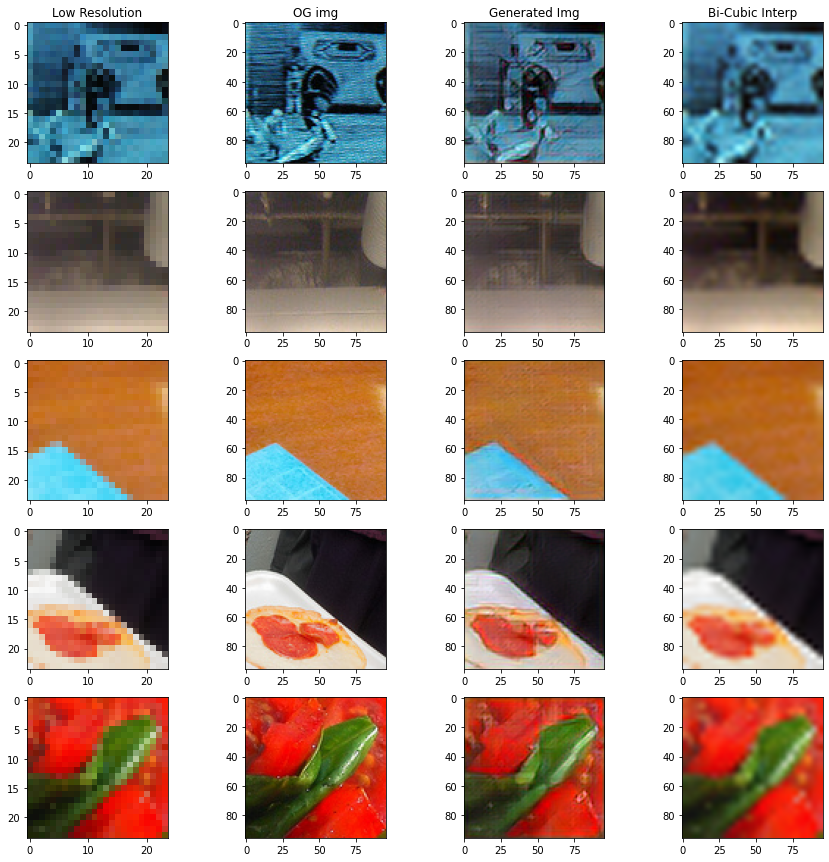

In [16]:
import random

plt.figure(figsize=(15,15)) 
for i in range(5):
    idx= random.randint(0,len(ImgDataset))
    lr,hr = prepare_Image_tf(ImgDataset[idx])
    # plotting the LR img
    plt.subplot(5,4,i*4+1)
    plt.imshow(lr)
    if i==0:
        plt.title("Low Resolution")

    # plotting the orignal img 
    plt.subplot(5,4,i*4+2)
    plt.imshow((hr+1)/2 )
    if i==0:
        plt.title("OG img")
    
    
    #now plotting the recovered image
    fake_imgs = Generator.predict(tf.expand_dims(lr,axis=0))
    plt.subplot(5,4,i*4+3)    
    plt.imshow((fake_imgs[0]+1)/2)
    if i==0:
        plt.title("Generated Img")
    
    # plotting the normal cubic interpolation 
    hr1= cv2.resize(lr.numpy(),dsize=(96,96),interpolation=cv2.INTER_CUBIC)
    hr1= cv2.normalize(np.array(hr1), 0, 1,dtype=cv2.CV_32F,norm_type=cv2.NORM_MINMAX)
    
    plt.subplot(5,4,i*4+4)
    plt.imshow(hr1) 
    if i==0:
        plt.title("Bi-Cubic Interp")

# References 

1. This was our first GAN model to write and we followed the steps of [Digitalsreeni on youtube](https://www.youtube.com/watch?v=1HqjPqNglPc&t). You can also find his github [here](https://github.com/bnsreenu/python_for_microscopists/tree/master/255_256_SRGAN). 
2. For the preprocessing, we tried to follow the steps written in the orignal paper itself, which you can find it [here](https://paperswithcode.com/method/srgan#:~:text=SRGAN%20is%20a%20generative%20adversarial,loss%20and%20a%20content%20loss.).

# Our Motive

Before doing this notebook we were actually looking for someone who replicated the results of the paper without manipulating the results or uploadig wrong code. 

Doing kaggle's save version, you can be confident that following the same steps will get u to the same results exactly. 

Although we are using loaded model in this demo, we were ititaly planning to make it run for 30 epochs as a full pipeline but we found out that kaggle won't allow us to run for more than 12 hrs :"") -u can see that in version 6-.

Feel Free to use the weights ^^

If this notebook was helpful don't forget to give us upvote ^^ 